## Travel Domain Question Classification

Following program classifies questions related to travel domain using a set of features which is described below.




Imports the required libraries and the data file

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import sqlite3
import pickle
%matplotlib inline
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

print('----- Importing dataset -----')
d_file = open('5000TravelQuestionsDataset.csv', encoding="latin-1")

df = pd.read_csv(d_file, header=None)
df.columns = ['text', 'class1', 'class2']

print ('Training Data : Imported Rows, Columns - ', df.shape)
print ('Data Preview :')
df.head()




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
----- Importing dataset -----
Training Data : Imported Rows, Columns -  (5000, 3)
Data Preview :


,text,class1,class2
0,What are the special things we (husband and me...,TTD,TTDSIG
1,What are the companies which organize shark fe...,TTD,TTDOTH
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA
3,What are the best places around Cape Town for ...,TTD,TTDSIG
4,What are the best places to stay for a family ...,ACM,ACMOTH


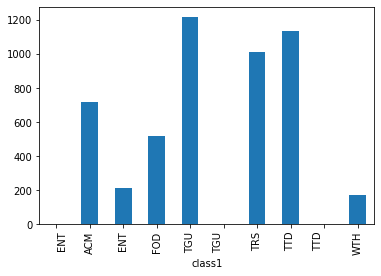

In [ ]:
df.groupby('class1').text.count().plot.bar(ylim=0)
plt.show()

The following section performs the text normalizing steps by converting text to lower case, removing leading and trailing whitespaces & removing stop words.

In [ ]:
# Text normalization steps
import string

# Function to remove stop words
def remove_stopwords(text):
  text_tokens = nltk.word_tokenize(text) 
  filtered_sentence = [word for word in text_tokens if not word in stopwords.words()] 
  return " ".join(filtered_sentence)

# Converting to lower case 
df['processed_text'] = df['text'].str.lower()
# Removing punctuations
translator = str.maketrans('', '', string.punctuation)
df['processed_text'] = df['processed_text'].str.translate(translator)
# Removing leading ending white spaces
df['processed_text'] = df['processed_text'].str.strip()
# Remove stop words
df['processed_text'] = df.processed_text.apply(remove_stopwords)


# Removing leading ending white spaces
df['class1'] = df['class1'].str.strip()
df['class2'] = df['class2'].str.strip()

df.head()


,text,class1,class2,processed_text
0,What are the special things we (husband and me...,TTD,TTDSIG,special things husband 5 day stay cape town
1,What are the companies which organize shark fe...,TTD,TTDOTH,companies organize shark feeding events scuba ...
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,safe female traveller go alone cape town
3,What are the best places around Cape Town for ...,TTD,TTDSIG,best places around cape town safari
4,What are the best places to stay for a family ...,ACM,ACMOTH,best places stay family stay away nightlife


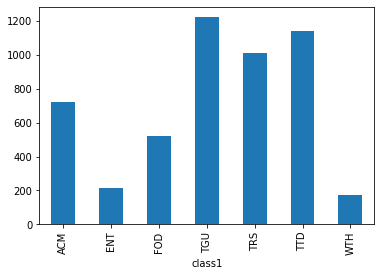

In [ ]:
df.groupby('class1').text.count().plot.bar(ylim=0)
plt.show()

# Lemmatizing

In [ ]:
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
  lemmatized = [lemmatizer.lemmatize(word, pos="v") for word in nltk.word_tokenize(text)]
  return ' '.join(lemmatized)

df['lemmatized'] = df.processed_text.apply(lemmatize_text)


# POS Tagging

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
# Modified POS tagger to retain words and apply tf idf vectoriser
def mod_pos_tagger(text):
    pos_tagged = [ r[0] + "_" + r[1] for r in pos_tag(nltk.word_tokenize(text))] 
    return ' '.join(pos_tagged)

df['pos_tagged'] = df.processed_text.apply(mod_pos_tagger)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


# Headword Extraction

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm')
def head_word_tokenizer(text):
    head_words = []
    for token in nlp(text):
        if token.dep_ == "nsubj" or token.dep_ == "dobj" or token.dep_ == "aux" or token.dep_ == "ROOT":
            head_words.append(token.text)
            head_words.append(token.head.text)
    unique_hw = list(set(head_words))
    return unique_hw

df['headwords'] = df.processed_text.apply(head_word_tokenizer)


# Headword Synonyms

In [ ]:
from nltk.corpus import wordnet
max_syns = 2

def wordnet_synonyms(keywords):
  synonyms = []
  for keyword in keywords:
    count = 0
    for synset in wordnet.synsets(keyword):
      if count <= max_syns:
        for lemma in synset.lemmas():
          if count <= max_syns:
            synonyms.append(lemma.name())
          else: 
            break
        count = count + 1
      else:
        break

  unique_synonyms = list(set(synonyms))
  return ' '.join(synonyms)

df['headwords_synonyms'] = df.headwords.apply(wordnet_synonyms)


In [ ]:
def join_strings(text):
  words = []
  for word in text:
    words.append(word)

  return ' '.join(words)

df['headwords'] = df.headwords.apply(join_strings)


# Named Entity Recognition

In [ ]:
def named_entity_tokenizer(text):
    named_entities = []
    for ent in nlp(text).ents:
      named_entities.append(ent.text + '_' + ent.label_)
    # unique_ent = list(set(named_entities))
    return ' '.join(named_entities)

df['named_entities'] = df.text.apply(named_entity_tokenizer)
df


,text,class1,class2,processed_text,lemmatized,pos_tagged,headwords,headwords_synonyms,named_entities
0,What are the special things we (husband and me...,TTD,TTDSIG,special things husband 5 day stay cape town,special things husband 5 day stay cape town,special_JJ things_NNS husband_VBP 5_CD day_NN ...,things husband stay,things thing thing husband hubby married_man c...,5 day_DATE Cape Town_FAC
1,What are the companies which organize shark fe...,TTD,TTDOTH,companies organize shark feeding events scuba ...,company organize shark feed events scuba divers,companies_NNS organize_VBP shark_JJ feeding_VB...,organize divers companies,form organize organise organize organise maste...,
2,Is it safe for female traveller to go alone to...,TGU,TGUHEA,safe female traveller go alone cape town,safe female traveller go alone cape town,safe_JJ female_NN traveller_NN go_VBP alone_RB...,go traveller,go spell tour turn Adam ecstasy XTC go disco_b...,Cape Town_GPE
3,What are the best places around Cape Town for ...,TTD,TTDSIG,best places around cape town safari,best place around cape town safari,best_JJS places_NNS around_IN cape_NN town_NN ...,places,topographic_point place spot place property place,Cape Town_LOC safari_GPE
4,What are the best places to stay for a family ...,ACM,ACMOTH,best places stay family stay away nightlife,best place stay family stay away nightlife,best_JJS places_NNS stay_VBP family_NN stay_VB...,places stay family,topographic_point place spot place property pl...,
...,...,...,...,...,...,...,...,...,...
4995,What is the best area to be based for sightsee...,TTD,TTDSIG,best area based sightseeing palma,best area base sightsee palma,best_JJS area_NN based_VBN sightseeing_NN palm...,area,area country area area region,Palma_ORG
4996,What are the good value traditional bars and r...,FOD,FODBAR,good value traditional bars restaurants barcelona,good value traditional bar restaurants barcelona,good_JJ value_NN traditional_JJ bars_NNS resta...,barcelona bars restaurants,Barcelona parallel_bars bars barroom bar saloo...,Barcelona_GPE
4997,What are the hotels near Alicante bus station?,ACM,ACMHOT,hotels near alicante bus station,hotels near alicante bus station,hotels_NNS near_IN alicante_JJ bus_NN station_NN,hotels,hotel,
4998,Where to stay in La Gomera to mountain biking?,TTD,TTDSPO,stay gomera mountain biking,stay gomera mountain bike,stay_NN gomera_NN mountain_NN biking_NN,biking stay,bicycle cycle bike pedal wheel stay arrest che...,La Gomera_ORG


# Label Encoder for Classes

In [ ]:
from sklearn.preprocessing import LabelEncoder
def label_encoder(text):
  le = LabelEncoder()
  y_encoded = le.fit_transform(text)

# Vectorize

Vectorize with TF IDF vectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_vectorize(text):
  tfidfconverter = TfidfVectorizer(max_features=1500, min_df=1, max_df=0.7, stop_words=stopwords.words('english'))
  vctzr = tfidfconverter.fit_transform(text).toarray()
  return vctzr

print('Bag of words -----')
tfidf_vectorize(df['lemmatized']).shape
print('Named Entity -----')
tfidf_vectorize(df['named_entities']).shape
print('Head Words -----')
tfidf_vectorize(df['headwords']).shape
print('Head Words Synonyms-----')
tfidf_vectorize(df['headwords_synonyms']).shape
print('POS tagged-----')
tfidf_vectorize(df['pos_tagged']).shape



Bag of words -----
Named Entity -----
Head Words -----
Head Words Synonyms-----
POS tagged-----


(5000, 1500)

# Accuracy Calculation

In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def accuracy_report(y_test, y_pred):
    
    print(classification_report(y_test,y_pred))

    acc = accuracy_score(y_test, y_pred)*100
    print('Accuracy : %.3f' % acc)

    print('F1 Score: %.3f' % f1_score(y_test, y_pred, average='weighted'))
    
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix: \n{}".format(cm))

# Model Creation and Training

The model uses the following features


1.   Bag of words
2.   Headwords
3.   Synonyms of headwords
4.   POS tags
5.   Name Entitiy Relations




In [ ]:
le = LabelEncoder()

x_encoded = np.concatenate((tfidf_vectorize(df['lemmatized']), tfidf_vectorize(df['named_entities']), tfidf_vectorize(df['headwords']), tfidf_vectorize(df['headwords_synonyms']), tfidf_vectorize(df['pos_tagged'])), axis=1)
y_encoded = le.fit_transform(df['class1'])

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


cv = KFold(n_splits=10, random_state=1, shuffle=True)
fold = 0
accuracies = []
for train_index, test_index in cv.split(x_encoded):
    fold += 1
    X_train, X_test = x_encoded[train_index], x_encoded[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(X_train,y_train)
    predictions_SVM1 = SVM.predict(X_test)
    acc = accuracy_score(predictions_SVM1, y_test)*100
    accuracies.append(acc)
    print("Fold: {} - {} - {:.2f}".format(fold, "Accuracy: ",acc))
    
print("Mean {:.2f} Standard Deviation {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

Fold: 1 - Accuracy:  - 79.00
Fold: 2 - Accuracy:  - 76.80
Fold: 3 - Accuracy:  - 74.80
Fold: 4 - Accuracy:  - 77.00
Fold: 5 - Accuracy:  - 74.40
Fold: 6 - Accuracy:  - 77.20
Fold: 7 - Accuracy:  - 74.40
Fold: 8 - Accuracy:  - 76.80
Fold: 9 - Accuracy:  - 75.00
Fold: 10 - Accuracy:  - 77.20
Mean 76.26 Standard Deviation 1.45


In [ ]:
le = LabelEncoder()

x_encoded = np.concatenate((tfidf_vectorize(df['lemmatized']), tfidf_vectorize(df['named_entities']), tfidf_vectorize(df['headwords']), tfidf_vectorize(df['headwords_synonyms']), tfidf_vectorize(df['pos_tagged'])), axis=1)
y_encoded = le.fit_transform(df['class2'])

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


cv = KFold(n_splits=10, random_state=1, shuffle=True)
fold = 0
accuracies = []
for train_index, test_index in cv.split(x_encoded):
    fold += 1
    X_train, X_test = x_encoded[train_index], x_encoded[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(X_train,y_train)
    predictions_SVMN = SVM.predict(X_test)
    acc = accuracy_score(predictions_SVMN, y_test)*100
    accuracies.append(acc)
    print("Fold: {} - {} - {:.2f}".format(fold, "Accuracy: ",acc))
    
print("Mean {:.2f} Standard Deviation {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

Fold: 1 - Accuracy:  - 58.40
Fold: 2 - Accuracy:  - 58.60
Fold: 3 - Accuracy:  - 58.40
Fold: 4 - Accuracy:  - 61.60
Fold: 5 - Accuracy:  - 58.00
Fold: 6 - Accuracy:  - 57.00
Fold: 7 - Accuracy:  - 55.20
Fold: 8 - Accuracy:  - 60.20
Fold: 9 - Accuracy:  - 58.40
Fold: 10 - Accuracy:  - 61.40
Mean 58.72 Standard Deviation 1.84


# Results

In [ ]:
accuracy_report(y_test, predictions_SVM1)

              precision    recall  f1-score   support

           0       0.03      1.00      0.05         2
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         0
           4       0.01      0.03      0.01        40
           5       0.02      0.10      0.03        21
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         3
          14       0.00      0.00      0.00        22
          15       0.00      0.00      0.00        16
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         2
          18       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
accuracy_report(y_test, predictions_SVMN)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           2       1.00      0.38      0.55         8
           4       0.58      0.70      0.64        40
           5       0.64      0.76      0.70        21
           6       1.00      0.80      0.89         5
           7       0.00      0.00      0.00         1
           8       0.70      0.88      0.78         8
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       0.86      0.86      0.86         7
          12       0.00      0.00      0.00         3
          14       0.72      0.82      0.77        22
          15       0.86      0.75      0.80        16
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         2
          18       1.00      1.00      1.00         1
          19       1.00      0.25      0.40         4
          20       0.67    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Removing Feature NER 
(Due to incompleteness - Certain records having null NER)

In [ ]:
le = LabelEncoder()

x_encoded = np.concatenate((tfidf_vectorize(df['lemmatized']), tfidf_vectorize(df['headwords']), tfidf_vectorize(df['headwords_synonyms']), tfidf_vectorize(df['pos_tagged'])), axis=1)
y_encoded = le.fit_transform(df['class1'])

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


cv = KFold(n_splits=10, random_state=1, shuffle=True)
fold = 0
accuracies = []
for train_index, test_index in cv.split(x_encoded):
    fold += 1
    X_train, X_test = x_encoded[train_index], x_encoded[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(X_train,y_train)
    predictions_SVM2 = SVM.predict(X_test)
    acc = accuracy_score(predictions_SVM1, y_test)*100
    accuracies.append(acc)
    print("Fold: {} - {} - {:.2f}".format(fold, "Accuracy: ",acc))
    
print("Mean {:.2f} Standard Deviation {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

Fold: 1 - Accuracy:  - 22.80
Fold: 2 - Accuracy:  - 24.00
Fold: 3 - Accuracy:  - 26.00
Fold: 4 - Accuracy:  - 27.80
Fold: 5 - Accuracy:  - 22.60
Fold: 6 - Accuracy:  - 24.00
Fold: 7 - Accuracy:  - 24.00
Fold: 8 - Accuracy:  - 22.20
Fold: 9 - Accuracy:  - 29.00
Fold: 10 - Accuracy:  - 77.20
Mean 29.96 Standard Deviation 15.89


In [ ]:
accuracy_report(y_test, predictions_SVM2)

              precision    recall  f1-score   support

           0       0.82      0.80      0.81        76
           1       0.88      0.65      0.75        23
           2       0.91      0.87      0.89        60
           3       0.69      0.71      0.70       112
           4       0.85      0.90      0.87        98
           5       0.69      0.72      0.71       114
           6       1.00      0.82      0.90        17

    accuracy                           0.78       500
   macro avg       0.84      0.78      0.81       500
weighted avg       0.79      0.78      0.78       500

Accuracy : 78.400
F1 Score: 0.785
Confusion Matrix: 
[[61  0  2  6  0  7  0]
 [ 1 15  2  3  1  1  0]
 [ 2  0 52  3  0  3  0]
 [ 4  0  1 80  7 20  0]
 [ 1  0  0  5 88  4  0]
 [ 4  1  0 19  8 82  0]
 [ 1  1  0  0  0  1 14]]


# Using only Bag of Words

In [27]:

le = LabelEncoder()

x_encoded = tfidf_vectorize(df['lemmatized'])
y_encoded = le.fit_transform(df['class1'])

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


cv = KFold(n_splits=10, random_state=1, shuffle=True)
fold = 0
accuracies = []
for train_index, test_index in cv.split(x_encoded):
    fold += 1
    X_train, X_test = x_encoded[train_index], x_encoded[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(X_train,y_train)
    predictions_SVM2 = SVM.predict(X_test)
    acc = accuracy_score(predictions_SVM2, y_test)*100
    accuracies.append(acc)
    print("Fold: {} - {} - {:.2f}".format(fold, "Accuracy: ",acc))
    
print("Mean {:.2f} Standard Deviation {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

Fold: 1 - Accuracy:  - 81.80
Fold: 2 - Accuracy:  - 80.60
Fold: 3 - Accuracy:  - 79.00
Fold: 4 - Accuracy:  - 78.80
Fold: 5 - Accuracy:  - 79.40
Fold: 6 - Accuracy:  - 79.60
Fold: 7 - Accuracy:  - 80.40
Fold: 8 - Accuracy:  - 80.00
Fold: 9 - Accuracy:  - 79.40
Fold: 10 - Accuracy:  - 80.80
Mean 79.98 Standard Deviation 0.88


In [ ]:
accuracy_report(y_test, predictions_SVM2)

              precision    recall  f1-score   support

           0       0.86      0.82      0.84        76
           1       0.94      0.74      0.83        23
           2       0.91      0.82      0.86        60
           3       0.76      0.74      0.75       112
           4       0.83      0.91      0.87        98
           5       0.71      0.79      0.75       114
           6       1.00      0.82      0.90        17

    accuracy                           0.81       500
   macro avg       0.86      0.80      0.83       500
weighted avg       0.81      0.81      0.81       500

Accuracy : 80.800
F1 Score: 0.809
Confusion Matrix: 
[[62  0  2  4  0  8  0]
 [ 0 17  1  2  2  1  0]
 [ 4  0 49  4  0  3  0]
 [ 3  0  2 83  7 17  0]
 [ 0  0  0  4 89  5  0]
 [ 3  1  0 12  8 90  0]
 [ 0  0  0  0  1  2 14]]


In [ ]:
le = LabelEncoder()

x_encoded = tfidf_vectorize(df['lemmatized'])
y_encoded = le.fit_transform(df['class2'])

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


cv = KFold(n_splits=10, random_state=1, shuffle=True)
fold = 0
accuracies = []
for train_index, test_index in cv.split(x_encoded):
    fold += 1
    X_train, X_test = x_encoded[train_index], x_encoded[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]
    SVM = SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    SVM.fit(X_train,y_train)
    predictions_SVM2 = SVM.predict(X_test)
    acc = accuracy_score(predictions_SVM2, y_test)*100
    accuracies.append(acc)
    print("Fold: {} - {} - {:.2f}".format(fold, "Accuracy: ",acc))
    
print("Mean {:.2f} Standard Deviation {:.2f}".format(np.mean(accuracies), np.std(accuracies)))

Fold: 1 - Accuracy:  - 62.00
Fold: 2 - Accuracy:  - 64.40
Fold: 3 - Accuracy:  - 65.00
Fold: 4 - Accuracy:  - 62.40
Fold: 5 - Accuracy:  - 65.40
Fold: 6 - Accuracy:  - 66.60
Fold: 7 - Accuracy:  - 63.80
Fold: 8 - Accuracy:  - 66.40
Fold: 9 - Accuracy:  - 63.80
Fold: 10 - Accuracy:  - 64.60
Mean 64.44 Standard Deviation 1.44


In [ ]:
accuracy_report(y_test, predictions_SVM2)

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           2       1.00      0.62      0.77         8
           4       0.64      0.68      0.66        40
           5       0.74      0.81      0.77        21
           6       1.00      0.80      0.89         5
           7       0.00      0.00      0.00         1
           8       0.75      0.75      0.75         8
           9       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         2
          11       1.00      0.71      0.83         7
          12       0.00      0.00      0.00         3
          13       0.00      0.00      0.00         0
          14       0.62      0.82      0.71        22
          15       1.00      0.81      0.90        16
          16       0.00      0.00      0.00         3
          17       0.00      0.00      0.00         2
          18       1.00      1.00      1.00         1
          19       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
